In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tag import StanfordPOSTagger
from nltk import word_tokenize
from nltk.internals import find_jars_within_path
import nltk
import sklearn.model_selection
from collections import Counter
import sklearn.feature_extraction.text as skt
from sklearn.feature_extraction.text import CountVectorizer

#nltk.download('punkt')

#from nltk.corpus import stopwords
#nltk.download('stopwords')

In [3]:
root = "/Users/ashleyroakes/Desktop/"
mim_root = root + "mimic-iii-clinical-database-1.4/"

# Data Pre-processing
## Read in Discharge Notes

In [4]:
notes = mim_root + "NOTEEVENTS.csv.gz"

notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False, 
                       usecols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION','TEXT'])\
                      .query("CATEGORY == 'Discharge summary'")\
                      .query("DESCRIPTION == 'Report'")

# Should be 55,177 records
print("Number of discharge summaries: ", + len(notes_df))

notes_df.head()

Number of discharge summaries:  55177


,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
0,22532,167853.0,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Report,Admission Date: [**2162-3-3**] D...


## Read in Patient Diagnoses

In [5]:
diag = mim_root + "DIAGNOSES_ICD.csv.gz"

diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\
                    .dropna()\
                    .groupby('HADM_ID')['ICD9_CODE']\
                    .unique()\
                    .reset_index()
diag_df.head()

,HADM_ID,ICD9_CODE
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ..."
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,..."
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V..."
3,100007,"[56081, 5570, 9973, 486, 4019]"
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148..."


## Read in ICD9 Dictionary

In [6]:
icd = mim_root + "D_ICD_DIAGNOSES.csv.gz"

icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)

icd_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## Merge datasets by HADM_ID

In [7]:
df = pd.merge(diag_df, notes_df, on='HADM_ID', how='inner')

# Should be 55177-5 = 55172
len(df)

55172

## Substitute special sequences,  Filter HoPI sections, & Tokenize

### Identify HOPI sections & Substitute Special Sequences: These special sequences were identified and replaced by the first token in the sequence, e.g. "[**Hospital1 18**]" was replaced by ‘Hospital1’.

In [8]:
def process_notes(st):
    s  = "History of Present Illness"
    s1 = "HISTORY OF PRESENT ILLNESS|HISTORY OF THE PRESENT ILLNESS|\nHISTORY:|present illness|Present Illness|PRESENT ILLNESS"
    
    match  = re.search(s, st)
    match1 = re.search(s1, st)
    
    if (match is not None) or (match1 is not None):
        if match is not None:
            st = st.split(s, 1)[1]
            e = "\n\n\n"
            n = st.split(e, 1)[0]
    
        elif match1 is not None: 
            st = st.split(match1[0], 1)[1]
            e = re.search(r"\n[\s\w]+:", st)[0]
            n = st.split(e, 1)[0]
        
        # Replace special strings with ""
        rep = re.findall(r"\[\*\*([a-zA-Z0-9]*)", n)
        strt = [m.start() for m in re.finditer("\[\*\*([a-zA-Z0-9]*)", n)]
        end = [m.end() for m in re.finditer("([a-zA-Z0-9]*)\*\*\]", n)]

        for i in range(len(rep)):
            n = n[:strt[i]] + rep[i] + " " + n[end[i] + 1:]
        
    else: 
        n = ''
    return n

In [9]:
df['HOPI'] = df["TEXT"].map(lambda t: process_notes(t))

### Number of missing HOPI sections

In [10]:
# Detect history of present illness in text (n = 2641 records without HoPI data)
df_hopi = df[df["HOPI"] != ""].reset_index()

missing = df[df["HOPI"] == ""].reset_index()

len(missing)

# Should be 2641 records
print("Notes without HOPI sections: " + str(len(missing)))

df_hopi

Notes without HOPI sections: 1867


,index,HADM_ID,ICD9_CODE,SUBJECT_ID,CATEGORY,DESCRIPTION,TEXT,HOPI
0,0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Discharge summary,Report,Admission Date: [**2117-9-11**] ...,:\n35F w/ poorly controlled Type 1 diabetes me...
1,1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Discharge summary,Report,Admission Date: [**2150-4-17**] ...,:\nMr. Known is a 59M w HepC cirrhosis c/b gra...
2,2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Discharge summary,Report,Admission Date: [**2108-4-6**] Discharg...,: This is a 48 year old African\nAmerican fem...
3,3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Discharge summary,Report,Admission Date: [**2145-3-31**] ...,:\nMs Known is a 73 year old female with a his...
4,4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Discharge summary,Report,Admission Date: [**2162-5-16**] ...,:\n60yo man with known coronary disease (AMI i...
...,...,...,...,...,...,...,...,...
53300,55167,199993,"[41031, 42821, 42731, 4271, 5180, 4240, 2760, ...",20785,Discharge summary,Report,Admission Date: [**2161-10-23**] Discha...,: The patient is a 60 year old man\nwith a hi...
53301,55168,199994,"[486, 4280, 51881, 3970, 496, 4169, 585, 42732...",23761,Discharge summary,Report,Admission Date: [**2188-7-7**] Discharg...,: The patient is a 58 year old woman\nwith mu...
53302,55169,199995,"[4210, 7464, 42971, 30401, 4412, 44284, V1259,...",19412,Discharge summary,Report,Admission Date: [**2137-12-11**] Discha...,: Known [**Known lastnameKnown male patient w...
53303,55170,199998,"[41401, 9971, 9975, 42731, 78820, 4111, V4582,...",27200,Discharge summary,Report,Admission Date: [**2119-2-18**] ...,:\nThis is a 69 year old male in known coronar...


### Initialize Stanford Tokenizer

In [11]:
# Add the jar and model via their path (instead of setting environment variables):
jar = root + 'stanford-postagger-full-2020-11-17/stanford-postagger.jar'
model = root + 'stanford-postagger-full-2020-11-17/models/english-left3words-distsim.tagger'

pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

# Add other jars from Stanford directory
stanford_dir = pos_tagger._stanford_jar.rpartition('/')[0]
stanford_jars = find_jars_within_path(stanford_dir)
pos_tagger._stanford_jar = ':'.join(stanford_jars)

### Tokenize, Remove Punctuation and Stop Words

In [12]:
# THIS CELL WILL BE REMOVED 
# For testing out other possible HOPI section headers

#PREOPERATIVE DIAGNOSIS (n = 6)
#ADMISSION DIAGNOSIS(es) (n = 38)(n = 45)
#ADMITTING DIAGNOSES (n = 7)
#HOSPITAL COURSE
#REASON FOR ADMISSION

ms = missing["TEXT"].map(lambda t: re.search("\nHISTORY:", t))
m = missing[~ms.isna()].reset_index()

cap = 138
lw = 15
lwlw = 12
hpi = 2
crs = 951
print(len(m))
#print(m["TEXT"][1])

#missing["TEXT"].to_csv(root + "no hopi.csv"

df["HOPI"][8]


0


':\nMr. Known is a 55 yo man with PMH significant for Downs\nSyndrome, MRSA pneumonia and respiratory failure in [**10/2187**]\nresulti10 tomy which was reversed [**2188-5-13**], who is\ntransfer2188 ubation at [**Hospital1 **] in [**Location (un) 1110**Hospital1 had been pLocation ce developing MRSA\npneumonia in [**10/2187**] (first [**Last Name (un) **] and then [**Hospital 5210 nters) and presentLast  from rehab for respiratorHospital been started on Rocephin [**5-22**] for preHospital1 t Rehab in setting of labored breathing.  Patient was\nintubated at [**Hospita5 labored breathing, accessory muscle\nuse.  Per report, there may have been some failed attempt in OSHHospital1 s tracheostomy prior to intubation.\n.\nAt OSH, patient received, levoquin 750mg @ 03:25, Vancomycin 1g\n@ 5:09 for pneumonia.  He was ordered for 4L NS and received at\nleast 2.5L. CXR and CT Chest appeared to show some fluid\noverload.  Patient was difficult to maintain on sedation; blood\npressure dropped on 

In [13]:
# Remove punctuation, non-characters, etc. 
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('\[\*\*[^\]]*\*\*\]', '', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('<[^>]*>', '', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('[\W]+', ' ', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub("\d+", " ", x))

# Tokenize
df_hopi['tokens'] = df_hopi["HOPI"].map(lambda n: word_tokenize(n))

### Truncate at 500 tokens

In [14]:
# Truncate records with more than 500 tokes (n = 1143)
count = df_hopi['tokens'].map(lambda c: len(np.unique(c)))

df_hopi["trunc"] = df_hopi['tokens'].map(lambda c: np.unique(c)[0:500])

print("Number of HOPI sections >= 500 tokens: " + str(len(df_hopi[count>=500])))

Number of HOPI sections >= 500 tokens: 1656


## Plot a histogram of the Number of tokens in each HoPI document, after data preprocessing.

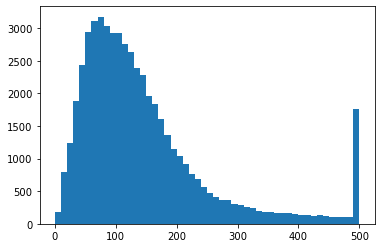

In [15]:
df_hopi["trunc_len"] = df_hopi['trunc'].map(lambda c: len(c))

plt.hist(df_hopi["trunc_len"], np.arange(0, 501, 10))
plt.show()

## Split data in train, valid, and test sets
### training (38,588 records, 69.9%), validation (5536 records, 10.0%) and testing (11,048 records, 20.0%) folds

In [17]:
# Random split
train, tst = sklearn.model_selection.train_test_split(df_hopi, test_size= 0.3, random_state=42)

test, valid = sklearn.model_selection.train_test_split(tst, test_size= 0.33, random_state=42)

In [837]:
# Get percentage of data in each set

37313

## Count number of tokens in the training dataset (n = ~92,468 tokens)

In [18]:
# Count occurence of tokens that are in the training dataset
n = len(np.unique(np.concatenate(train["trunc"].values)))
occ = Counter(np.concatenate(train["trunc"].values))
             
# Tokens that occur >= 5 times are in the study vocabulary (should be ~19,503)
vocab = [k for k,v in occ.items() if v >= 5]
len(vocab)

# Assign a unique integer ID for each token in the study vocabulary 
vocab_lookup = dict(zip(vocab, np.arange(0, len(vocab), 1)))

# Convert each HoPI document to a 1D array of integers using this index
df_hopi["trunc_idx"] = df_hopi["trunc"].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])

# Document representation

In [19]:
# Represent clinical notes documents as TF-IDF representation
#skt.TfidfVectorizer().fit_transform(df_hopi["trunc"])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(np.concatenate(train["trunc"]))

vectorizer.get_feature_names_out()

KeyError: 1

In [ ]:
# Mean embedding representation

In [ ]:
# GRU representation

# Label representation